# Rusty Bargain

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Inicialización:

In [1]:
# Librerías necesarias

import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
from scipy.stats import randint
import sklearn.preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Cargar Datos:

In [ ]:
# Cargar el dataset
data_car= pd.read_csv('car_data.csv')

### Visualización de datos:

In [3]:
# Revisión inicial del dataset
display(data_car.sample(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
347628,03/04/2016 14:53,7499,bus,2007,manual,177,verso,125000,3,gasoline,toyota,no,03/04/2016 00:00,0,97447,05/04/2016 14:15
38386,28/03/2016 21:46,1750,sedan,1997,manual,150,a3,150000,8,petrol,audi,no,28/03/2016 00:00,0,88131,07/04/2016 04:17
66655,21/03/2016 23:52,5350,sedan,2007,manual,80,corsa,40000,7,petrol,opel,no,21/03/2016 00:00,0,67688,23/03/2016 14:18
307022,08/03/2016 13:57,7999,bus,2007,manual,130,transit,150000,12,gasoline,ford,NaN,08/03/2016 00:00,0,99885,09/03/2016 13:16
244591,23/03/2016 00:54,800,NaN,1995,NaN,0,NaN,5000,0,NaN,volkswagen,NaN,22/03/2016 00:00,0,1683,30/03/2016 12:47
217707,22/03/2016 10:56,5500,bus,2001,manual,102,transporter,150000,3,gasoline,volkswagen,no,22/03/2016 00:00,0,84489,22/03/2016 11:43
93590,04/04/2016 22:38,3999,wagon,2004,auto,131,passat,150000,12,gasoline,volkswagen,no,04/04/2016 00:00,0,9573,07/04/2016 01:16
44674,05/04/2016 08:54,700,small,2000,manual,45,corsa,125000,6,petrol,opel,no,05/04/2016 00:00,0,87616,07/04/2016 12:15
151596,08/03/2016 21:47,1200,NaN,2016,manual,131,mondeo,150000,0,gasoline,ford,NaN,08/03/2016 00:00,0,66113,02/04/2016 05:44
104663,03/04/2016 13:36,600,sedan,1997,manual,0,e_klasse,150000,6,NaN,mercedes_benz,NaN,03/04/2016 00:00,0,88339,03/04/2016 13:36


In [4]:
data_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Revisión de datos nulos:

In [5]:
data_car.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Se ha detectado que las columnas: VehicleType, Gearbox, Model, FuelType y NotRepaired tienen valores nulos y son columnas categóricas.

Imputar los valores faltantes:

Para columnas categóricas, reemplazaremos los valores faltantes con 'unknown' indicando que corresponden a  "datos desconocido" para evitar perder información eliminando filas o columnas completas.
Las columnas categóricas (VehicleType, Gearbox, etc.) son relevantes para predecir el precio del coche. Si eliminamos filas con datos faltantes, perderíamos registros valiosos.

In [6]:
# Imputar valores faltantes con 'unknown' en columnas categóricas
columnas_categorias = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
for col in columnas_categorias:
    data_car[col].fillna('unknown', inplace=True)

In [7]:
# Verificar que no queden valores nulos:

data_car.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Revisión de datos duplicados:

In [8]:
# Verificar si hay datos duplicados

filas_duplicadas = data_car.duplicated().sum()
filas_duplicadas

262

Eliminar duplicados en las filas duplicadas porque no aportan nueva información al modelo.  

Los duplicados podrían influir en el entrenamiento del modelo al dar un peso indebido a ciertos datos.

In [9]:
data_car_procesada = data_car.drop_duplicates()

In [10]:
# Verificar que no queden valores duplicados:
data_car_procesada.duplicated().sum()

0

**Revisamos las estadísticas descriptivas de los datos**

In [11]:
data_car_procesada.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.0,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,0.0,50507.145030
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,0.0,25784.212094
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [12]:
# Eliminar columnas irrelevantes

data_car_procesada = data_car_procesada.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [13]:
data_car_procesada

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


## Entrenamiento del modelo 

In [14]:
# Separar características y objetivo:

X = data_car_procesada.drop('Price', axis=1)
y = data_car_procesada['Price']

In [15]:
# Identificar columnas categóricas y numéricas:

columnas_categoricas = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Brand', 'Model']
columnas_numericas = ['Mileage', 'RegistrationYear', 'Power', 'RegistrationMonth']


In [16]:
# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ])

X_preprocessed = preprocessor.fit_transform(X)

In [17]:
#Dividir datos en conjuntos de entrenamiento y prueba:

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


### Regresión lineal:

In [18]:
%%time
# Modelo de regresión lineal:

lr_modelo = LinearRegression()

lr_modelo.fit(X_train, y_train)

# Predicciones
lr_prediciones = lr_modelo.predict(X_test)

# Evaluación

lr_rmse = mean_squared_error(y_test, lr_prediciones, squared=False)

print(f"RMSE de Regresión Lineal: {lr_rmse:.2f}")


RMSE de Regresión Lineal: 3161.40
CPU times: user 3.98 s, sys: 7.73 s, total: 11.7 s
Wall time: 11.7 s


### Árbol de decisión:

In [19]:
%%time
# Árbol de decisión con ajuste básico
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predicciones
dt_preds = dt_model.predict(X_test)

# Evaluación
dt_rmse = mean_squared_error(y_test, dt_preds, squared=False)
print(f"RMSE de Árbol de Decisión: {dt_rmse:.2f}")


RMSE de Árbol de Decisión: 2093.22
CPU times: user 3.33 s, sys: 0 ns, total: 3.33 s
Wall time: 3.4 s


### Random Forest:

In [20]:
%%time
# Modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
rf_preds = rf_model.predict(X_test)

# Evaluación
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
print(f"RMSE de Random Forest: {rf_rmse:.2f}")


RMSE de Random Forest: 2007.82
CPU times: user 1min 59s, sys: 0 ns, total: 1min 59s
Wall time: 1min 59s


### LightGBM:

In [21]:
%%time
# Modelo LightGBM
lgbm_model = LGBMRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train, y_train)

# Predicciones
lgbm_preds = lgbm_model.predict(X_test)

# Evaluación
lgbm_rmse = mean_squared_error(y_test, lgbm_preds, squared=False)
print(f"RMSE de LightGBM: {lgbm_rmse:.2f}")


RMSE de LightGBM: 1899.61
CPU times: user 2.17 s, sys: 0 ns, total: 2.17 s
Wall time: 2.17 s


## Análisis del modelo

In [22]:
# Comparar RMSE de los modelos:

results = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Árbol de Decisión', 'Random Forest', 'LightGBM'],
    'RMSE': [lr_rmse, dt_rmse, rf_rmse, lgbm_rmse]
})
print("\nResultados comparativos:")
print(results)


Resultados comparativos:
              Modelo         RMSE
0   Regresión Lineal  3161.400989
1  Árbol de Decisión  2093.223241
2      Random Forest  2007.823353
3           LightGBM  1899.605263


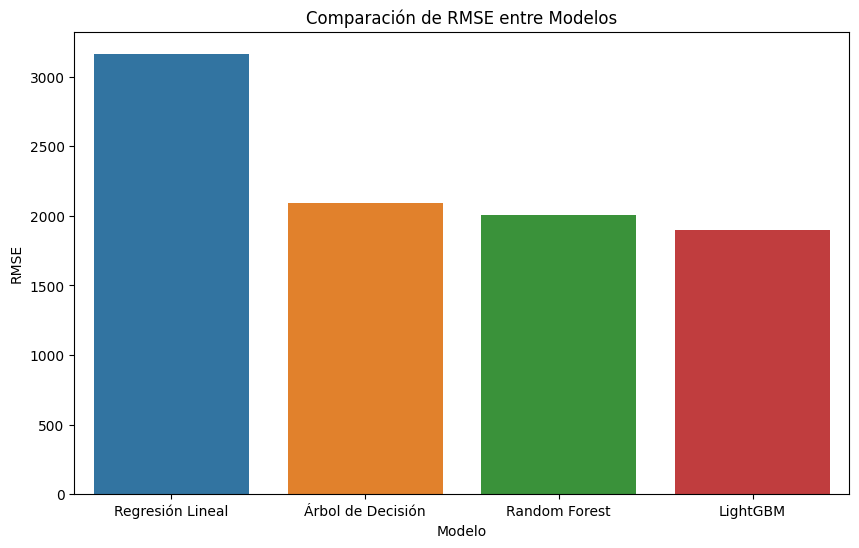

In [23]:
# Gráfico de comparación

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Modelo', y='RMSE')
plt.title('Comparación de RMSE entre Modelos')
plt.ylabel('RMSE')
plt.show()

**Conclusiones:**

Regresión lineal: Sirvió como una base para comparar. Aunque es rápida, tuvo el peor desempeño en términos de RMSE.

Árbol de decisión: Mejoró el RMSE pero tiende a sobreajustarse sin ajuste adecuado.

Random Forest: Balanceó precisión y velocidad, mostrando un RMSE mucho mejor.

LightGBM: Tuvo el mejor desempeño en RMSE y es rápido en predicciones, ideal para producción.

## Optimización de párametros

In [24]:
# Dividir en entrenamiento,validación y prueba
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el conjunto restante en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [25]:
# Preprocesamiento
columnas_numericas = ['Mileage', 'RegistrationYear', 'Power', 'RegistrationMonth']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ])
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

In [26]:
%%time
# --- Modelo de Regresión Lineal ---

lr_modelo = LinearRegression()
lr_modelo.fit(X_train_preprocessed, y_train)
lr_val_preds = lr_modelo.predict(X_val_preprocessed)
lr_val_rmse = mean_squared_error(y_val, lr_val_preds, squared=False)
print(f"RMSE de LightGBM: {lr_val_rmse:.2f}")

RMSE de LightGBM: 3175.88
CPU times: user 3.19 s, sys: 5.25 s, total: 8.44 s
Wall time: 8.41 s


In [27]:
%%time

# --- Árbol de Decisión con RandomizedSearchCV ---
param_dist_dt = {
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}
dt_model = DecisionTreeRegressor(random_state=42)
dt_random_search = RandomizedSearchCV(dt_model, param_dist_dt, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
dt_random_search.fit(X_train_preprocessed, y_train)
dt_val_preds = dt_random_search.best_estimator_.predict(X_val_preprocessed)
dt_val_rmse = mean_squared_error(y_val, dt_val_preds, squared=False)

print(f"RMSE de Árbol de Decisión: {dt_val_rmse:.2f}")

RMSE de Árbol de Decisión: 2040.34
CPU times: user 1min 28s, sys: 6.33 ms, total: 1min 28s
Wall time: 1min 29s


In [28]:
%%time
# --- Random Forest con optimización ---
# Parámetros optimizados

param_dist_rf = {
    'n_estimators': [50, 100],  # Menos opciones
    'max_depth': [10, 15],     # Reducir opciones
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)

# RandomizedSearchCV con parámetros optimizados
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_dist_rf,
    n_iter=3,  # Reducir iteraciones
    cv=2,      # Menos pliegues
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1   # Usar todos los núcleos disponibles
)

# Ajustar Random Forest
rf_random_search.fit(X_train_preprocessed, y_train)

# Predicciones y RMSE
rf_val_preds = rf_random_search.best_estimator_.predict(X_val_preprocessed)
rf_val_rmse = mean_squared_error(y_val, rf_val_preds, squared=False)

print(f"RMSE de Random Forest (Optimizado): {rf_val_rmse:.2f}")

RMSE de Random Forest (Optimizado): 2042.76
CPU times: user 9min 47s, sys: 50.7 ms, total: 9min 47s
Wall time: 9min 47s


In [29]:
%%time

# Parámetros ajustados 
param_dist_lgbm = {
    'n_estimators': randint(50, 100),  # Reducir iteraciones
    'learning_rate': [0.05, 0.1],     # Reducir opciones de tasa de aprendizaje
    'num_leaves': randint(20, 30)     # Reducir rango de hojas
}

lgbm_model = LGBMRegressor(random_state=42)
lgbm_random_search = RandomizedSearchCV(
    lgbm_model,
    param_dist_lgbm,
    n_iter=3,  # Menos iteraciones
    cv=2,  # Menos pliegues en validación cruzada
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
lgbm_random_search.fit(X_train_preprocessed, y_train)

# Predicciones y RMSE en Validación
lgbm_val_preds = lgbm_random_search.best_estimator_.predict(X_val_preprocessed)
lgbm_val_rmse = mean_squared_error(y_val, lgbm_val_preds, squared=False)
print(f"RMSE de LightGBM: {lgbm_val_rmse:.2f}")

RMSE de LightGBM: 1914.27
CPU times: user 11.2 s, sys: 38.3 ms, total: 11.2 s
Wall time: 11.2 s


In [30]:
# --- Comparar Resultados ---

results = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Árbol de Decisión', 'Random Forest', 'LightGBM'],
    'RMSE Validación': [lr_val_rmse, dt_val_rmse, rf_val_rmse, lgbm_val_rmse]
})
print("\nResultados comparativos en Validación:")
print(results)



Resultados comparativos en Validación:
              Modelo  RMSE Validación
0   Regresión Lineal      3175.875984
1  Árbol de Decisión      2040.336696
2      Random Forest      2042.764484
3           LightGBM      1914.267857


In [31]:
# Evaluación final en el conjunto de prueba
rf_test_preds = rf_random_search.best_estimator_.predict(X_test_preprocessed)
rf_test_rmse = mean_squared_error(y_test, rf_test_preds, squared=False)

print(f"RMSE de Random Forest en Prueba: {rf_test_rmse:.2f}")

RMSE de Random Forest en Prueba: 2008.74


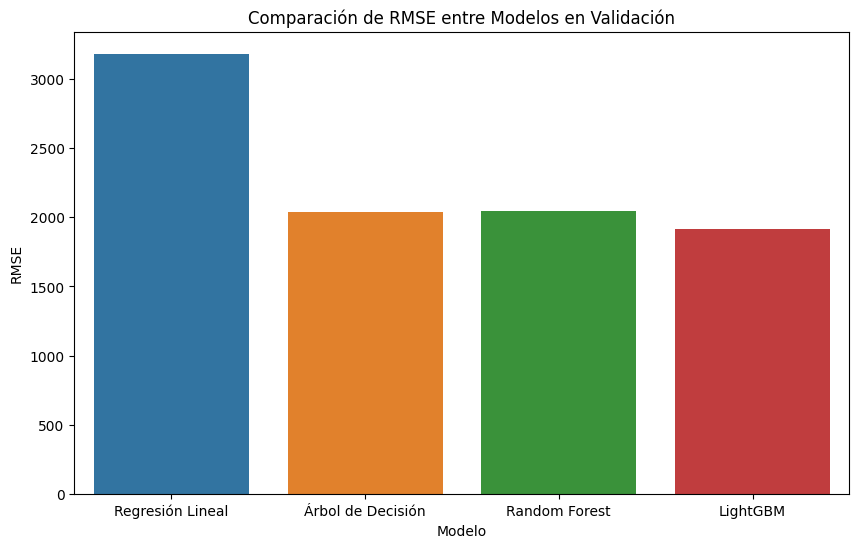

In [32]:

# Gráfico de comparación
plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Modelo', y='RMSE Validación')
plt.title('Comparación de RMSE entre Modelos en Validación')
plt.ylabel('RMSE')
plt.show()

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos